# Import Libraries and Datasets

In [1]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from src.preprocessing_functions import check_image_dimensions, sharpen, noise_reduction, load_and_plot_augmented_images
from src.data_viz_functions import plot_sample_images, plot_class_distribution, compute_brightness_contrast, compute_edge_density, compute_sharpness
from src.data_viz_functions import load_random_image, display_images, compute_mean_color_histogram, plot_canny_edges

In [2]:
# Load paths in a dict for train, test, valid folders with wildfire and nowildfire images 

images_path = '/Users/silvanoquarto/Desktop/PROJECTS/Data_Wildfire_Project'
splits = ['train', 'test', 'valid']
labels = ['wildfire', 'nowildfire']

image_paths = {f"{split}_{label}": [] for split in splits for label in labels}

for split in splits:
    for label in labels:
        path = os.path.join(images_path, split, label)
        if os.path.exists(path):  
            image_files = os.listdir(path)
            full_paths = [os.path.join(path, img) for img in image_files]
            image_paths[f"{split}_{label}"].extend(full_paths)
            print(f"- {split.capitalize()} set for {label} uploaded correctly!!")
        else:
            print(f"Warning: {path} does not exist :(")

- Train set for wildfire uploaded correctly!!
- Train set for nowildfire uploaded correctly!!
- Test set for wildfire uploaded correctly!!
- Test set for nowildfire uploaded correctly!!
- Valid set for wildfire uploaded correctly!!
- Valid set for nowildfire uploaded correctly!!


# Data overview about datasets statistcs

In [3]:
# Labels distribution 

for split in splits:
    wildfire_count = len(image_paths[f"{split}_wildfire"])
    nowildfire_count = len(image_paths[f"{split}_nowildfire"])
    total_count = wildfire_count + nowildfire_count
    print("-"*30)
    print(f"{split.capitalize()} set:") 
    print(f"Wildfire: {wildfire_count}")
    print(f"No wildfire: {nowildfire_count}")
    print(f"Total: {total_count}")
    print("-"*30)

------------------------------
Train set:
Wildfire: 15750
No wildfire: 14499
Total: 30249
------------------------------
------------------------------
Test set:
Wildfire: 3479
No wildfire: 2820
Total: 6299
------------------------------
------------------------------
Valid set:
Wildfire: 3480
No wildfire: 2820
Total: 6300
------------------------------


In [4]:
# Verify Dataset split percentages

image_counts = {f"{split}_{category}": 0 for split in splits for category in labels}

for split in splits:
    for label in labels:
        path = os.path.join(images_path, split, label)
        image_counts[f"{split}_{label}"] = len(os.listdir(path))

total_images = sum(image_counts.values())
train_images = image_counts['train_wildfire'] + image_counts['train_nowildfire']
test_images = image_counts['test_wildfire'] + image_counts['test_nowildfire']
val_images = image_counts['valid_wildfire'] + image_counts['valid_nowildfire']

print("-"*45)
print(f"Total images: {total_images}")
print(f"Total images expected: {22710+20140}")
print("-"*45)
print(f"Train set: {train_images} images, {train_images / total_images:.2%} of total")
print(f"Train set expected: ~70%")
print("-"*45)
print(f"Test set: {test_images} images, {test_images / total_images:.2%} of total")
print(f"Test set expected: ~15%")
print("-"*45)
print(f"Validation set: {val_images} images, {val_images / total_images:.2%} of total")
print(f"Validation set expected: ~15%")
print("-"*45)

---------------------------------------------
Total images: 42848
Total images expected: 42850
---------------------------------------------
Train set: 30249 images, 70.60% of total
Train set expected: ~70%
---------------------------------------------
Test set: 6299 images, 14.70% of total
Test set expected: ~15%
---------------------------------------------
Validation set: 6300 images, 14.70% of total
Validation set expected: ~15%
---------------------------------------------


In [5]:
# Verify corrupted files and images dimensions 
# if the some images have different dimensions respect to the expected 350x350 this function prints a warning

corrupted_img = {"files" : [],
                 "paths" : []
                 }

check_image_dimensions(images_path, splits, labels, corrupted_img)

In [6]:
# Remove corrupted files

for file_name, relative_path in zip(corrupted_img['files'], corrupted_img['paths']):
    file_path = os.path.join(images_path, relative_path, file_name)
    try:
        os.remove(file_path)
        print(f"Removed corrupted file: {file_path}")
    except OSError as e:
        print(f"Error removing file {file_path}: {e}")

Removed corrupted file: /Users/silvanoquarto/Desktop/PROJECTS/Data_Wildfire_Project/train/nowildfire/-114.152378,51.027198.jpg
Removed corrupted file: /Users/silvanoquarto/Desktop/PROJECTS/Data_Wildfire_Project/test/wildfire/-73.15884,46.38819.jpg


In [7]:
# Verify removal

for file_name, relative_path in zip(corrupted_img['files'], corrupted_img['paths']):
    file_path = os.path.join(images_path, relative_path, file_name)
    if not os.path.exists(file_path):
        print(f"File successfully removed: {file_path}")
    else:
        print(f"File still exists: {file_path}")

File successfully removed: /Users/silvanoquarto/Desktop/PROJECTS/Data_Wildfire_Project/train/nowildfire/-114.152378,51.027198.jpg
File successfully removed: /Users/silvanoquarto/Desktop/PROJECTS/Data_Wildfire_Project/test/wildfire/-73.15884,46.38819.jpg


# Data Visualization

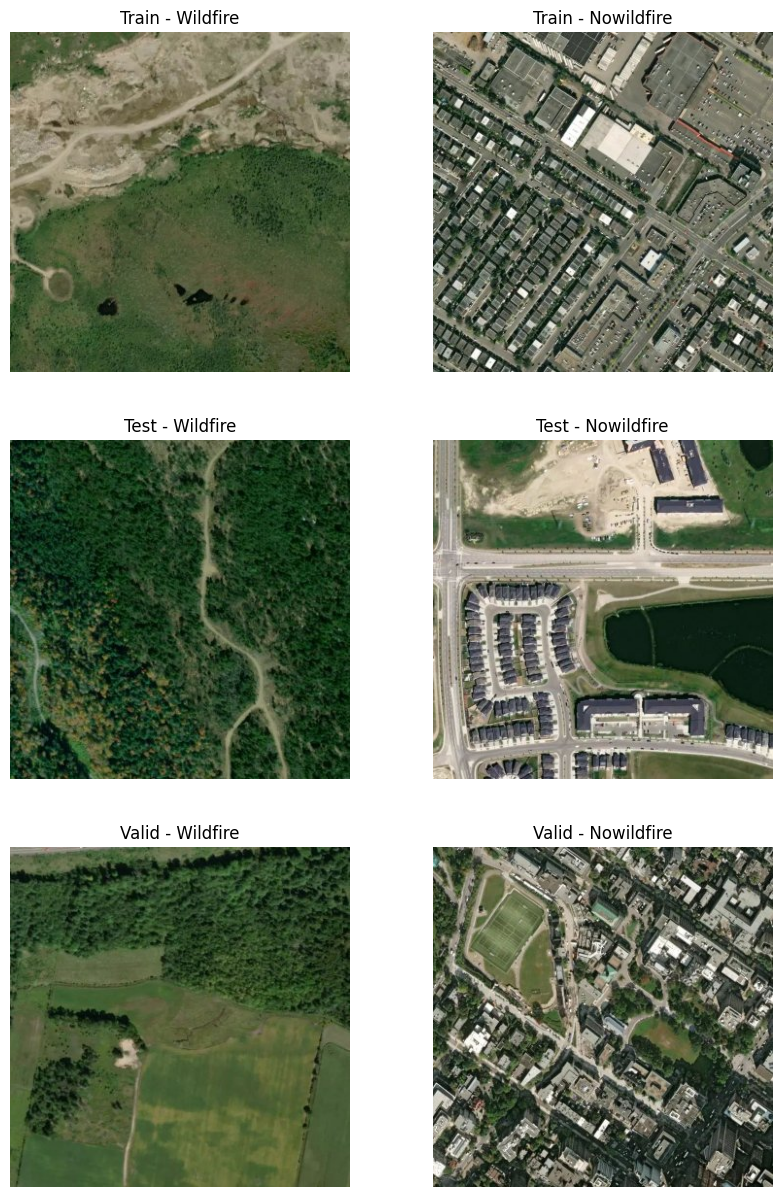

In [9]:
# Plot random images about wildfire and no wildfire images for each folder

plot_sample_images(images_path, splits, labels)

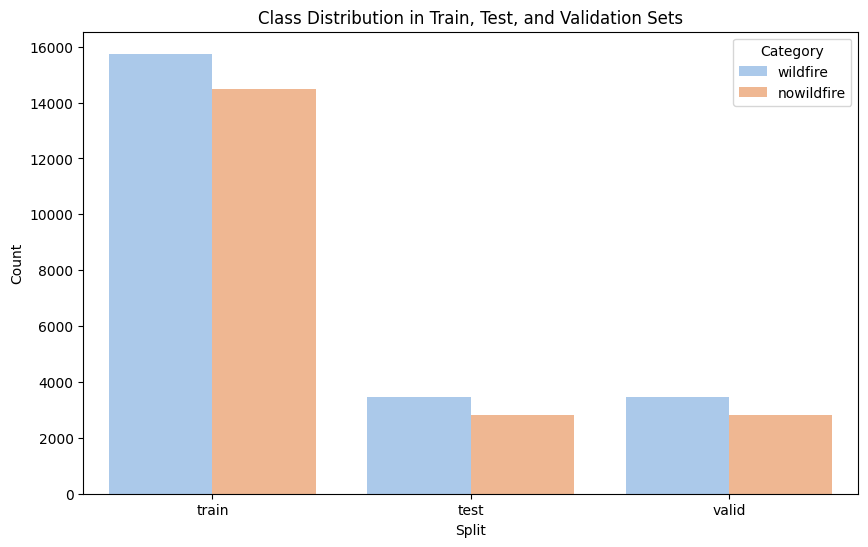

In [5]:
# Plot class distribution

plot_class_distribution(images_path, splits, labels)

# Image Quality Analysis

In [15]:
# Evaluate brightness and contrast 

brightness_contrast_data = {'split': [], 'labels': [], 'brightness': [], 'contrast': []}

for split in splits:
    for label in labels:
        path = os.path.join(images_path, split, label)
        for img_name in os.listdir(path):  
            img_path = os.path.join(path, img_name)
            brightness, contrast = compute_brightness_contrast(img_path)
            brightness_contrast_data['split'].append(split)
            brightness_contrast_data['labels'].append(label)
            brightness_contrast_data['brightness'].append(brightness)
            brightness_contrast_data['contrast'].append(contrast)

df_brightness_contrast = pd.DataFrame(brightness_contrast_data)
df_brightness_contrast.head()

split    labels  brightness   contrast
0  train  wildfire   50.001959  23.929410
1  train  wildfire   72.995690  51.300990
2  train  wildfire   56.277665  15.482274
3  train  wildfire   81.135731  11.268528
4  train  wildfire   55.379796  17.988645

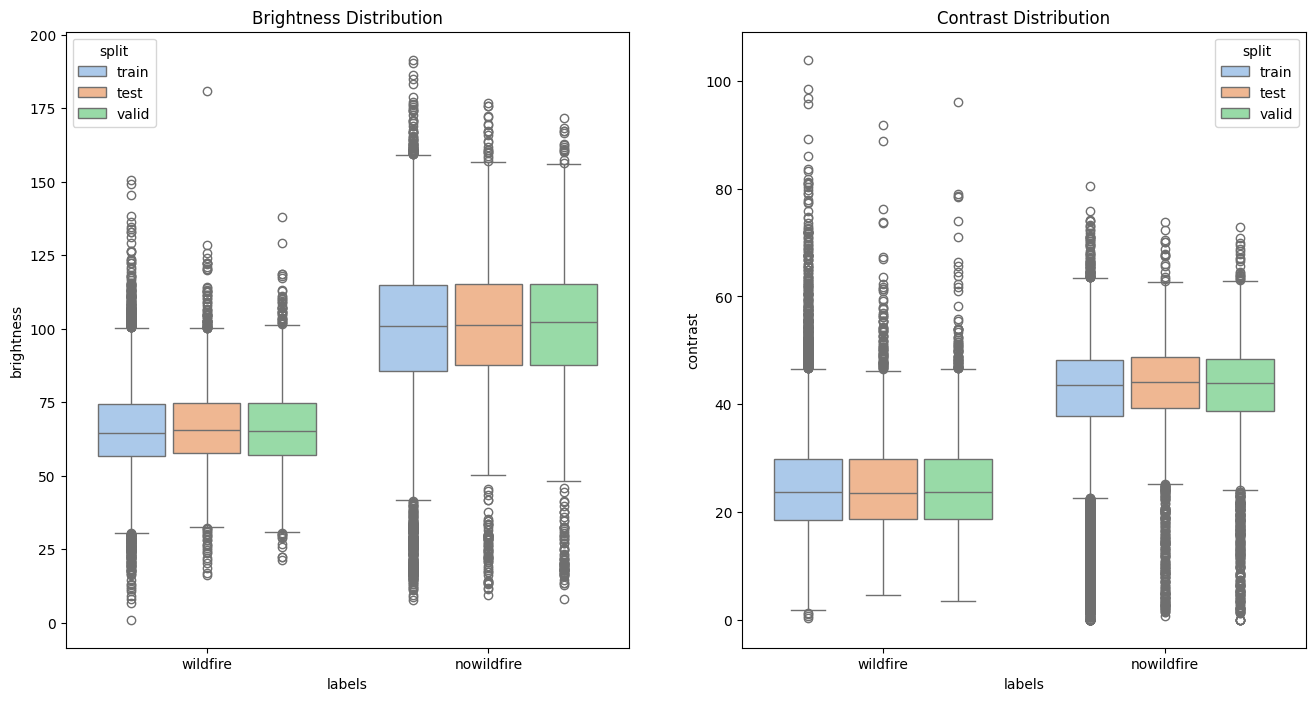

In [23]:
# Plot brightness and contrast bar plots

plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
sns.boxplot(x='labels', y='brightness', hue='split', data=df_brightness_contrast, palette='pastel', gap=0.1)
plt.title('Brightness Distribution')

plt.subplot(1, 2, 2)
sns.boxplot(x='labels', y='contrast', hue='split', data=df_brightness_contrast, palette='pastel', gap=0.1)
plt.title('Contrast Distribution')

plt.show()

In [8]:
# Evaluate edge density using Canny's filter

edge_density = {'split': [], 'labels': [], 'density': []}

for split in splits:
    for label in labels:
        path = os.path.join(images_path, split, label)
        for img_name in os.listdir(path):  
            img_path = os.path.join(path, img_name)
            density = compute_edge_density(img_path)
            edge_density['split'].append(split)
            edge_density['labels'].append(label)
            edge_density['density'].append(density)

df_edge_density = pd.DataFrame(edge_density)
df_edge_density.head()

split    labels    density
0  train  wildfire  75.875510
1  train  wildfire  74.330939
2  train  wildfire  56.674531
3  train  wildfire   3.166163
4  train  wildfire  43.807959

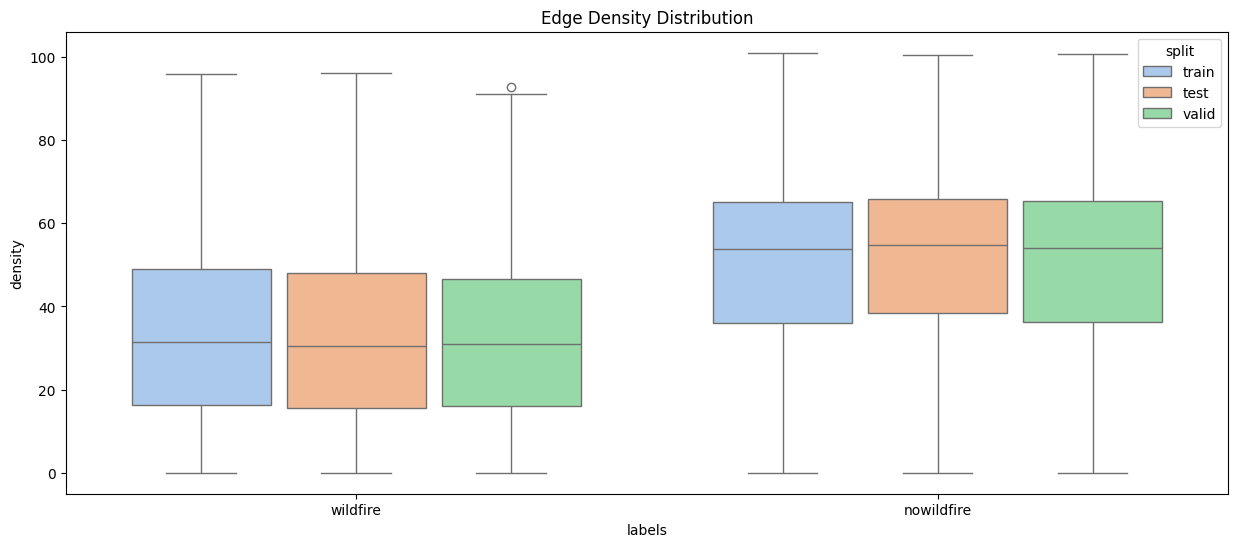

In [18]:
# Plot edge density distribution

plt.figure(figsize=(15,6))

sns.boxplot(x='labels', y='density', hue='split', data=df_edge_density, palette='pastel', gap=0.1)
plt.title('Edge Density Distribution')

plt.show()

In [21]:
# Evaluate sharpness using Laplacian operator

sharpness = {'split': [], 'labels': [], 'sharpness': []}

for split in splits:
    for label in labels:
        path = os.path.join(images_path, split, label)
        for img_name in os.listdir(path):  
            img_path = os.path.join(path, img_name)
            sharp = compute_sharpness(img_path)
            sharpness['split'].append(split)
            sharpness['labels'].append(label)
            sharpness['sharpness'].append(sharp)

df_sharpness = pd.DataFrame(sharpness)
df_sharpness.head()

split    labels    sharpness
0  train  wildfire  1425.703810
1  train  wildfire  6541.444110
2  train  wildfire  1066.015469
3  train  wildfire    99.024330
4  train  wildfire   641.600302

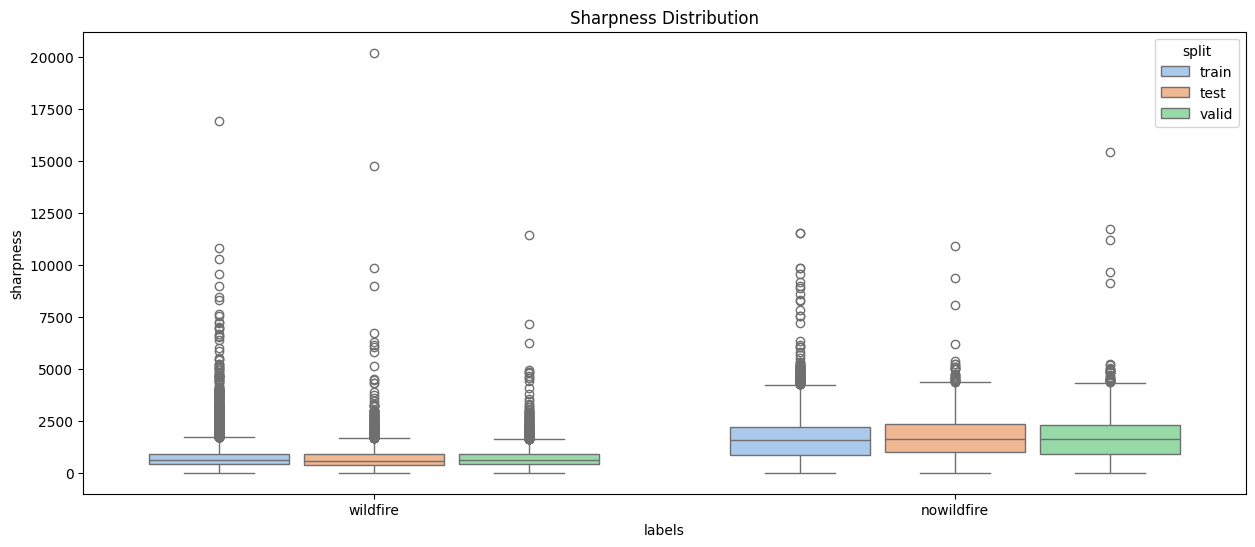

In [22]:
# Plot edge sharpness distribution

plt.figure(figsize=(15,6))

sns.boxplot(x='labels', y='sharpness', hue='split', data=df_sharpness, palette='pastel', gap=0.1)
plt.title('Sharpness Distribution')

plt.show()

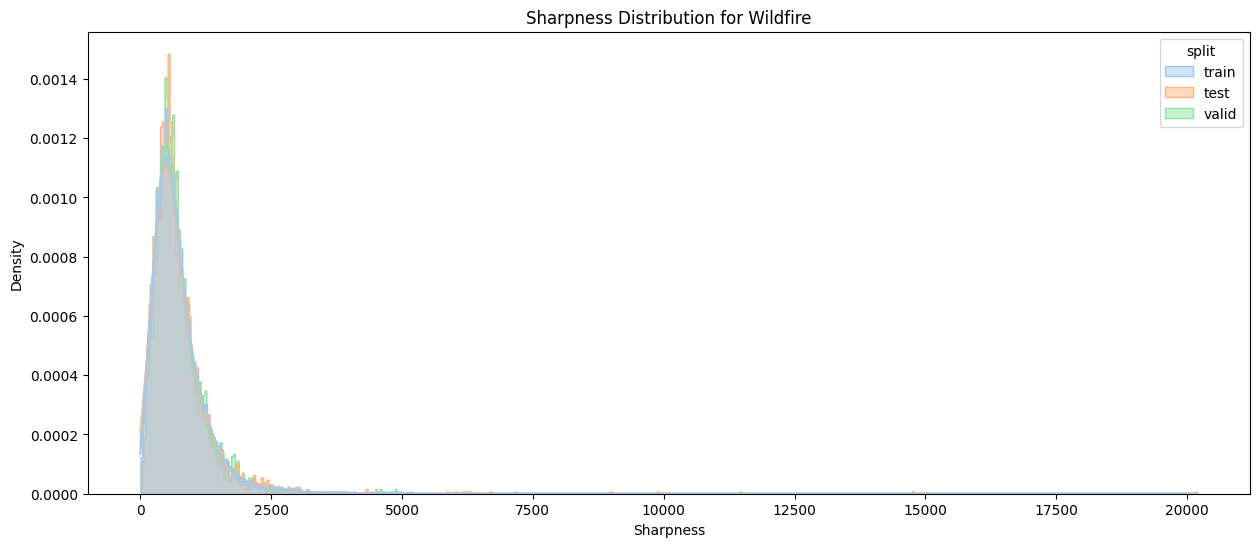

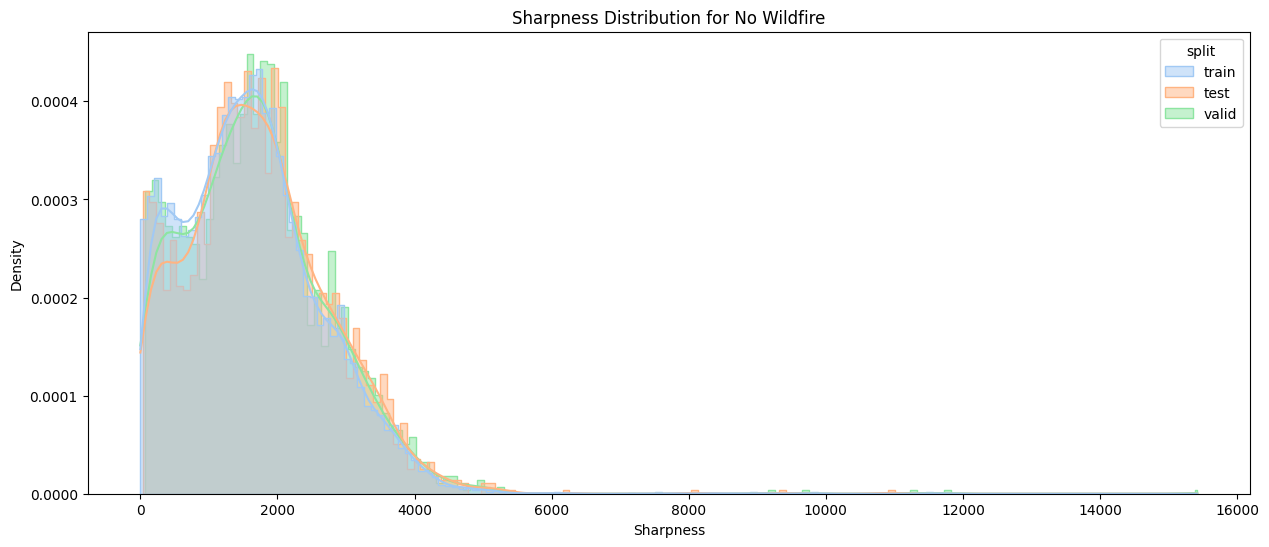

In [28]:
# Plot sharpness histogram distribution

wildfire_df = df_sharpness[df_sharpness['labels'] == 'wildfire']
nowildfire_df = df_sharpness[df_sharpness['labels'] == 'nowildfire']

plt.figure(figsize=(15, 6))

sns.histplot(data=wildfire_df, x='sharpness', hue='split', kde=True, element="step", stat="density", common_norm=False, palette='pastel', multiple="dodge")
plt.title('Sharpness Distribution for Wildfire')
plt.xlabel('Sharpness')
plt.ylabel('Density')
plt.show()

plt.figure(figsize=(15, 6))
sns.histplot(data=nowildfire_df, x='sharpness', hue='split', kde=True, element="step", stat="density", common_norm=False, palette='pastel', multiple="dodge")
plt.title('Sharpness Distribution for No Wildfire')
plt.xlabel('Sharpness')
plt.ylabel('Density')
plt.show()

# Data Enhancement and Augmentation

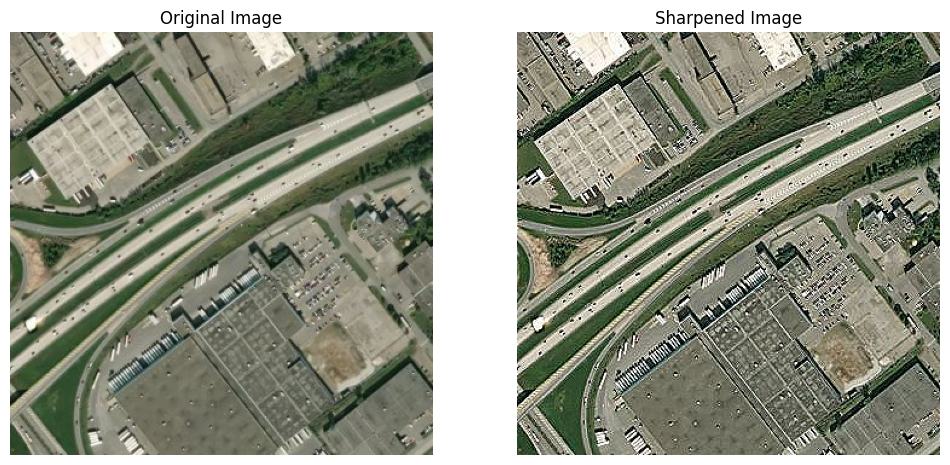

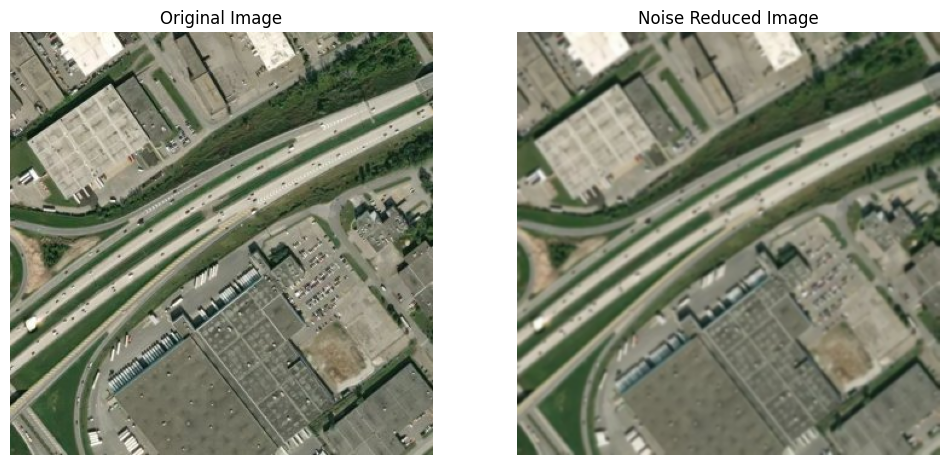

In [5]:
# Load a random image
random_image = load_random_image(images_path)

# Apply and show sharpening and noise reduction
sharpened_image = sharpen(random_image)
display_images(random_image, sharpened_image, 'Sharpened Image')

blurred_image = noise_reduction(random_image)
display_images(random_image, blurred_image, 'Noise Reduced Image')

In [8]:
# Enhance sharpness for each image in each folder

for split in splits:
    for label in labels:

        category_path = os.path.join(images_path, split, label)
        image_files = os.listdir(category_path)

        for image_file in image_files:

            image_path = os.path.join(category_path, image_file)
            image = cv2.imread(image_path)
            
            if image is not None:
                sharpened_image = sharpen(image)
                cv2.imwrite(image_path, sharpened_image)
            else:
                print(f"Failed to read {image_path}")

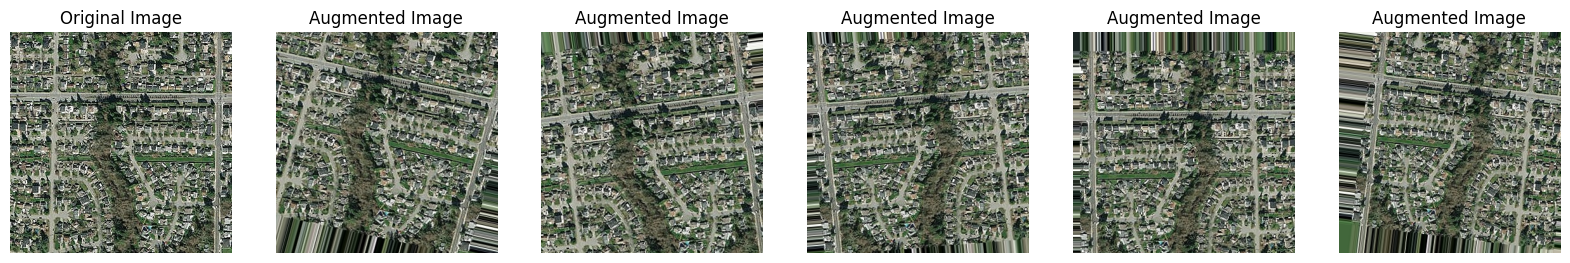

In [3]:
# Function to plot original and augmented images

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

load_and_plot_augmented_images(images_path, datagen)

# Advanced Data Quality Analysis and Visualization

In [8]:
# Plot pixel intensity about every image in a folder with Blue, Green and Red channel histogram 
split_name = 'train'          # 'train', 'test', or 'valid'
category_name = 'wildfire'  # 'wildfire' or 'nowildfire'

mean_hist_b, mean_hist_g, mean_hist_r = compute_mean_color_histogram(images_path, split_name, category_name)

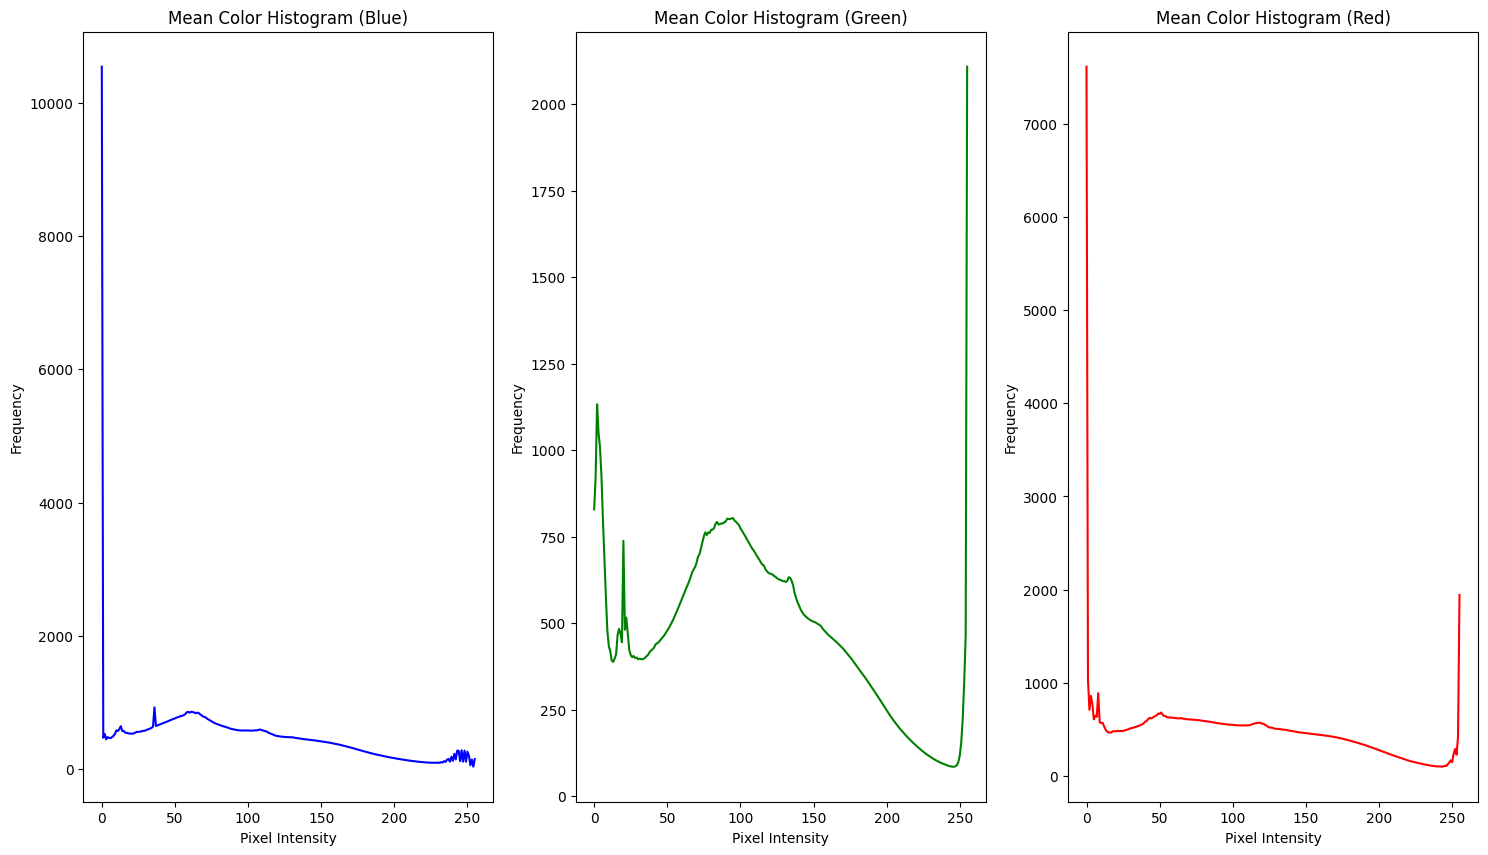

In [7]:
# TRAIN - NOWILDFIRE

plt.figure(figsize=(18, 10))

plt.subplot(1, 3, 1)
plt.plot(mean_hist_b, color='b')
plt.title('Mean Color Histogram (Blue)')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')

plt.subplot(1, 3, 2)
plt.plot(mean_hist_g, color='g')
plt.title('Mean Color Histogram (Green)')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')

plt.subplot(1, 3, 3)
plt.plot(mean_hist_r, color='r')
plt.title('Mean Color Histogram (Red)')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')

plt.show()

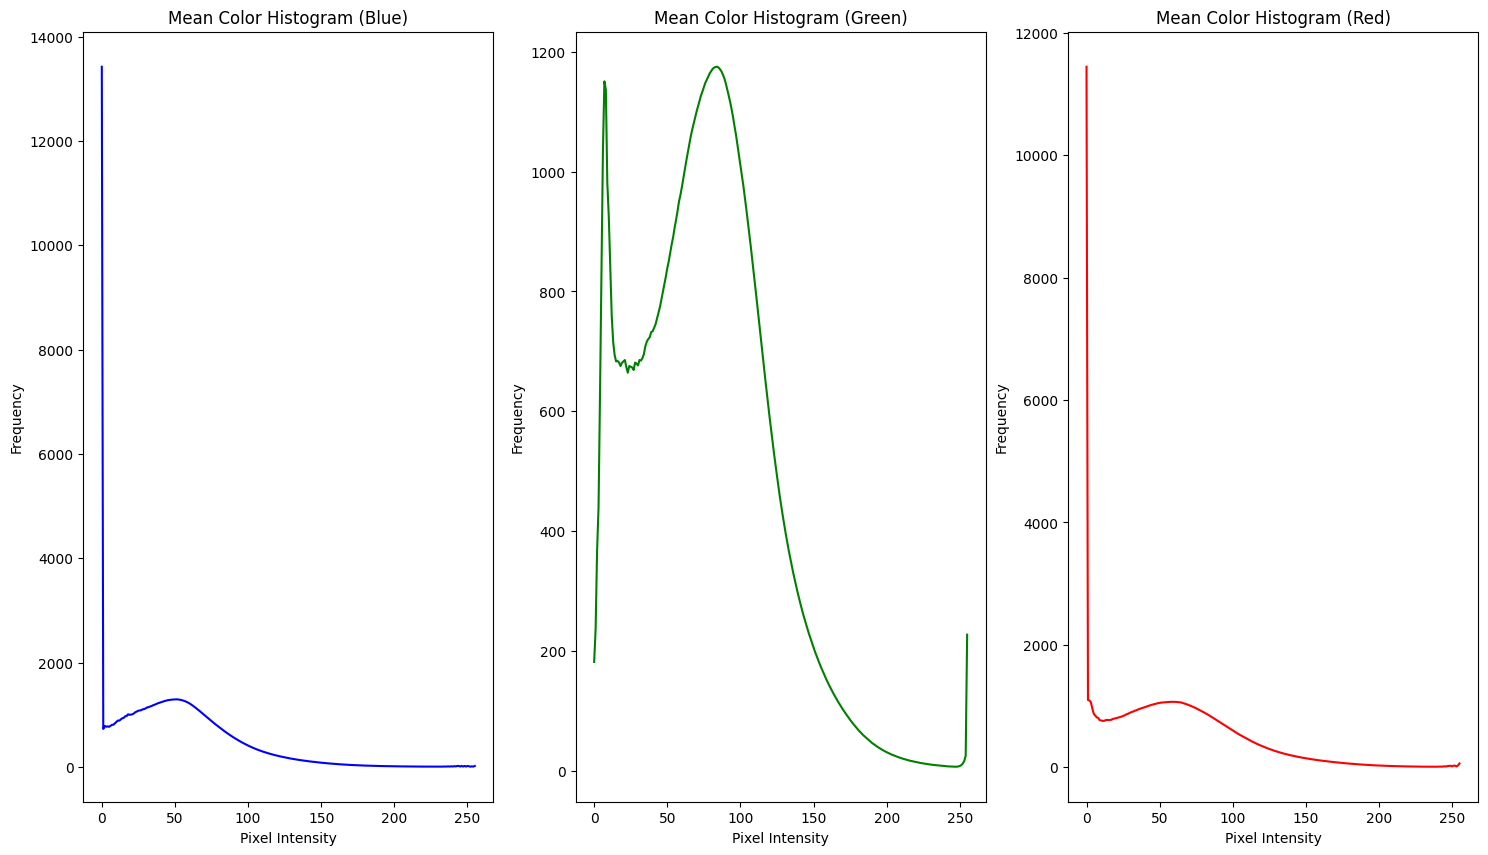

In [9]:
# TRAIN - WILDFIRE

plt.figure(figsize=(18, 10))

plt.subplot(1, 3, 1)
plt.plot(mean_hist_b, color='b')
plt.title('Mean Color Histogram (Blue)')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')

plt.subplot(1, 3, 2)
plt.plot(mean_hist_g, color='g')
plt.title('Mean Color Histogram (Green)')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')

plt.subplot(1, 3, 3)
plt.plot(mean_hist_r, color='r')
plt.title('Mean Color Histogram (Red)')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')

plt.show()

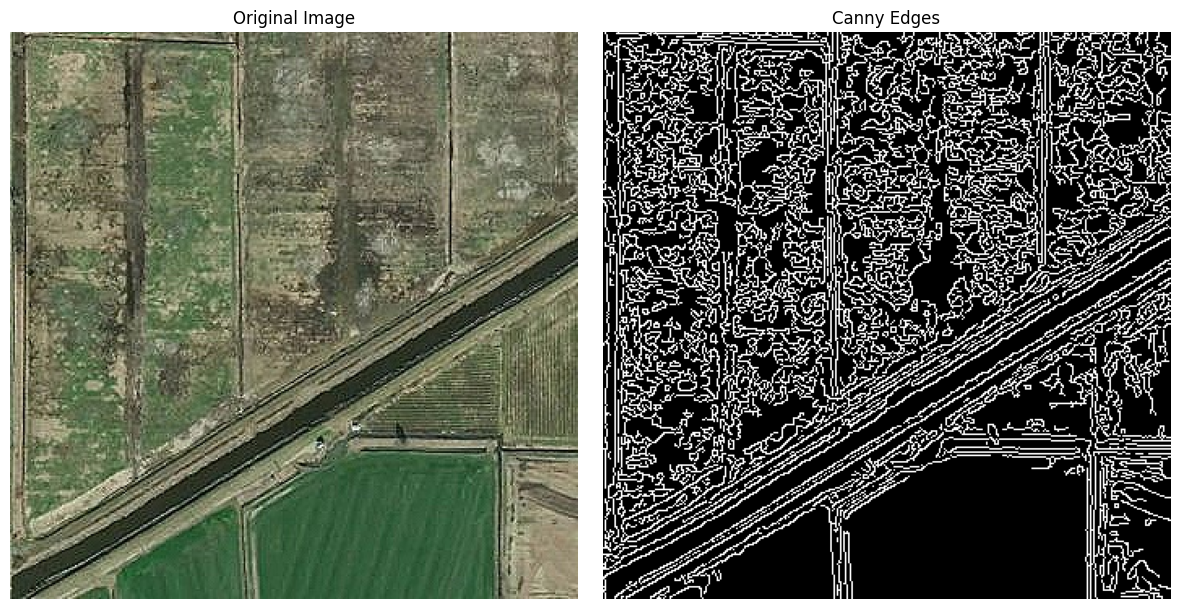

In [10]:
# Plot random image with Canny's filter 

random_image = load_random_image(images_path)
    
plot_canny_edges(random_image)
